## Intro

In [1]:
import ekkono.primer as primer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import plotly.graph_objs as go
primer.Primer.version()

'24.4'

In [2]:
figsize = (6,2)
round = 2

## Read

In [3]:
data_directory = '../../data/original/ARN-20240611/ARN-20240611-gsv_including_null.txt'
df = pd.read_csv(data_directory, index_col='ts', sep=', ', engine='python')
df.head()

,id,elevation,azimuth,snr,x,y
ts,,,,,,
63300,29,72,96,46,-3,30
63300,1,57,279,42,8,-53
63300,26,49,285,40,16,-63
63300,31,42,254,43,-20,-71
63300,18,36,186,44,-80,-8


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 19637 entries, 63300 to 71524
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         19637 non-null  int64
 1   elevation  19637 non-null  int64
 2   azimuth    19637 non-null  int64
 3   snr        19637 non-null  int64
 4   x          19637 non-null  int64
 5   y          19637 non-null  int64
dtypes: int64(6)
memory usage: 1.0 MB


,id,elevation,azimuth,snr,x,y
count,19637.000000,19637.000000,19637.000000,19637.000000,19637.000000,19637.000000
mean,41.689667,30.593421,186.334318,23.146000,7.392473,-3.410755
std,29.860437,21.775657,104.528918,16.550783,59.783317,56.763243
min,1.000000,0.000000,0.000000,0.000000,-93.000000,-99.000000
25%,16.000000,12.000000,84.000000,0.000000,-56.000000,-54.000000
50%,29.000000,25.000000,185.000000,25.000000,6.000000,-6.000000
75%,74.000000,47.000000,279.000000,39.000000,64.000000,59.000000
max,196.000000,84.000000,360.000000,52.000000,100.000000,99.000000


<Axes: xlabel='ts'>

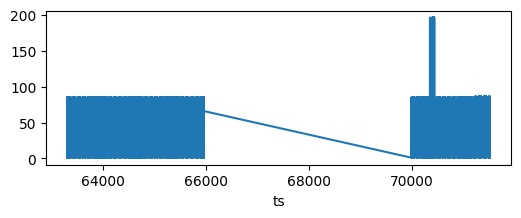

In [5]:
df['id'].unique()
df['id'].plot(figsize=figsize)

## EDA

In [6]:
csv_name = '../../data/processed/df_rearranged_with_null.csv'
if round == 1:
    df_new = utils.rearrange_df(df)
    df_new = utils.time_parse(df_new, data_directory)
    df_new.to_csv(csv_name)

In [7]:
df_new = pd.read_csv(csv_name, index_col=0, parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
# display(df_new.head())

In [8]:
variable_to_keep = 'snr'
df_snr = utils.keep_one_signal(variable_to_keep,
                               df_new)
display(df_snr.head())

,snr_29,snr_1,snr_26,snr_31,snr_18,snr_25,snr_28,snr_20,snr_5,snr_4,...,snr_73,snr_76,snr_67,snr_68,snr_84,snr_83,snr_196,snr_27,snr_69,snr_86
2024-06-11 06:33:00,46.0,42.0,40.0,43.0,44.0,24.0,45.0,0.0,28.0,29.0,...,45.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-11 06:33:03,46.0,44.0,41.0,44.0,44.0,22.0,45.0,0.0,28.0,31.0,...,45.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-11 06:33:06,46.0,45.0,41.0,44.0,44.0,23.0,45.0,0.0,27.0,35.0,...,44.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-11 06:33:09,46.0,45.0,41.0,43.0,44.0,24.0,45.0,0.0,27.0,35.0,...,44.0,33.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-11 06:33:12,46.0,44.0,41.0,44.0,43.0,26.0,45.0,0.0,28.0,38.0,...,43.0,33.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_plot = df_snr
index_tags_times = utils.event_parser_times(data_directory)
html_name = '../../figures/signals_snr.html'
utils.plotly_df(df_plot, html_name, index_tags_times)

### Derivatives idea

In [10]:
df_snr_diff1 = df_snr.diff(periods=5).sum(axis='columns')
df_snr_diff10 = df_snr.diff(periods=10).sum(axis='columns')
df_snr_diff = pd.concat([df_snr_diff1, df_snr_diff10], axis='columns')
# utils.plotly_df(df_snr_diff, html_name, index_tags_times)

## Keep "best" signals (no NaNs)

Do anomaly detection on max or 75th percentile?

In [11]:
df_snr.shape[0]

849

In [12]:
print('original shape', df_snr.shape)
percentage_not_na = 0.8
keep_mask = df_snr.notna().sum()/df_snr.shape[0] > percentage_not_na
keep_signals = df_snr.columns[keep_mask]
drop_signals = [col for col in df_snr.columns if col not in keep_signals]
df_snr.drop(columns=drop_signals, inplace=True)
print('shape for only best features', df_snr.shape)
df_snr.head()

original shape (849, 29)
shape for only best features (849, 21)


,snr_29,snr_1,snr_26,snr_31,snr_18,snr_25,snr_28,snr_20,snr_5,snr_4,...,snr_9,snr_75,snr_74,snr_85,snr_66,snr_76,snr_67,snr_68,snr_84,snr_83
2024-06-11 06:33:00,46.0,42.0,40.0,43.0,44.0,24.0,45.0,0.0,28.0,29.0,...,31.0,42.0,41.0,48.0,44.0,35.0,NaN,NaN,NaN,NaN
2024-06-11 06:33:03,46.0,44.0,41.0,44.0,44.0,22.0,45.0,0.0,28.0,31.0,...,32.0,40.0,41.0,49.0,42.0,32.0,NaN,NaN,NaN,NaN
2024-06-11 06:33:06,46.0,45.0,41.0,44.0,44.0,23.0,45.0,0.0,27.0,35.0,...,31.0,40.0,41.0,49.0,41.0,30.0,NaN,NaN,NaN,NaN
2024-06-11 06:33:09,46.0,45.0,41.0,43.0,44.0,24.0,45.0,0.0,27.0,35.0,...,28.0,41.0,40.0,49.0,40.0,33.0,0.0,NaN,NaN,NaN
2024-06-11 06:33:12,46.0,44.0,41.0,44.0,43.0,26.0,45.0,0.0,28.0,38.0,...,29.0,41.0,40.0,48.0,42.0,33.0,0.0,0.0,NaN,NaN


In [13]:
df_snr.ffill(inplace=True)
type(df_snr)

pandas.core.frame.DataFrame

In [14]:
df_plot = df_snr
html_name = '../../figures/best_signals_snr.html'
# index_tags = utils.event_parser()
# utils.plotly_df(df_plot, html_name, index_tags_times)

In [15]:
window = 5
max_values = df_snr.rolling(window).quantile(0.2)
max_values
df_snr_max = df_snr.join(max_values, rsuffix='_max'+str(window)).dropna()
html_name = '../../figures/best_signals_snr_max5.html'

df_plot = df_snr_max
# utils.plotly_df(df_plot, html_name, index_tags_times)

In [16]:
min_values = df_snr.rolling(window=5).min()
min_values
df_snr_min = df_snr.join(max_values, rsuffix='_min').dropna()
df_plot = df_snr_min
# utils.plotly_df(df_plot, html_name, index_tags_times)

Easy solution: take min() and take the max of the highest values of that?

## Groundtruth signal

In [17]:
df_snr = utils.add_column_location(df_snr, index_tags_times)

## Signals to model

In [18]:
target = 'location'
windows = [5]
pipeline_creator = utils.PipelineCreator(df_snr, target)
df_snr_diff = pipeline_creator.add_deltas(windows)
utils.plotly_df2(df_snr_diff, df_snr[target], html_name, index_tags_times)

In [19]:
windows = [5]
df_snr_mins = pipeline_creator.add_mins(windows)
utils.plotly_df2(df_snr_mins, df_snr[target], html_name, index_tags_times)

In [20]:
# html_name = '../../figures/signals_to_detect.html'
# utils.plotly_df2(df_snr_diff, df_snr_mins, html_name, index_tags_times) # to plot in two different axis

## Detectors
One change detector and one anomaly detector?

In [21]:
df_selected_signals = pd.concat([df_snr_diff, df_snr_mins], axis='columns') 

In [22]:
df = df_snr_diff # Specify here which signals you want the anomaly detector on
n_points_calibration = 200
nbr_of_points = 200
sensitivity = 150
anomaly_scores, targets = utils.anomaly_detector(df, n_points_calibration, nbr_of_points, sensitivity, target, df_snr)

RAM memory usage (excluding pipeline): 7.568 kB


In [23]:
title_plot = str(targets)+'_anomaly_detector'
utils.create_line_plot(anomaly_scores, title_plot)

Delay of 15-40 seconds in detecting entrance/exit event

best results n_points = 200, and sens = 150 approx, but RAM = 8kB
